train (217, 6), val (46, 6), test (47, 6)
VAR(1) MSE   val=4.393   test=10.372


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


epoch  30  loss 3.5919
epoch  60  loss 3.5596
epoch  90  loss 5.5436
epoch 120  loss 2.9764
epoch 150  loss 1.9501
LSTM‑VAE RMSE (last‑step): 3.137
KS distances: {'SP500_Returns': np.float64(0.4722222222222222), 'GS10_Level': np.float64(0.5833333333333334), 'FEDFUNDS_Level': np.float64(0.8611111111111112), 'FEDFUNDS_BpsChange': np.float64(0.5555555555555556), 'Inflation_YoY': np.float64(0.9444444444444444), 'Inflation_YoY_diff': np.float64(0.5555555555555556)}
metrics saved at ./results/baseline/


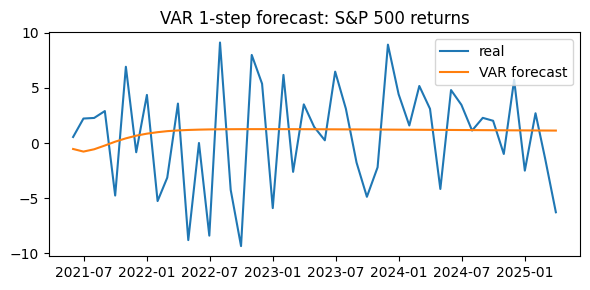

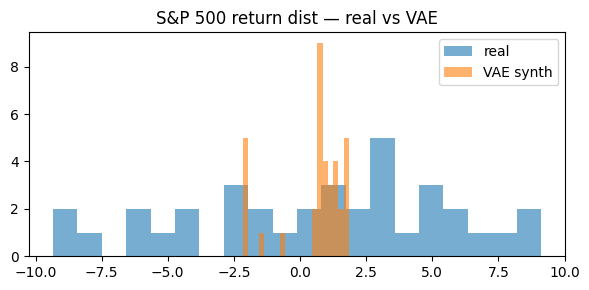

In [1]:
# =============================================================
# 0 ─ Imports & paths  (Colab‑safe)
# =============================================================
import warnings, os, json, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.api import VAR

# reproducibility
np.random.seed(42); torch.manual_seed(42)

DATA_PATH = "./final_processed_data.csv"
OUT_DIR   = "./results/baseline/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1 ─ Load & temporal split
# =============================================================
df = pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
features = df.columns.tolist()

n = len(df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train = df.iloc[:train_end]
val   = df.iloc[train_end:val_end]
test  = df.iloc[val_end:]

print(f"train {train.shape}, val {val.shape}, test {test.shape}")

# =============================================================
# 2 ─ VAR(1) benchmark
# =============================================================
var = VAR(train)
var_res = var.fit(maxlags=1)

def roll_fore(model, history_df, horizon):
    preds = []
    hist  = history_df.copy()
    for _ in range(horizon):
        next_ = model.forecast(hist.values[-1:], steps=1)[0]
        preds.append(next_)
        next_idx = hist.index[-1] + pd.DateOffset(months=1)
        hist = pd.concat([hist,
                          pd.DataFrame([next_], columns=hist.columns,
                                       index=[next_idx])])
    return np.vstack(preds)

val_pred  = roll_fore(var_res, train, len(val))
test_pred = roll_fore(var_res, pd.concat([train, val]), len(test))

var_val_mse  = np.mean((val.values - val_pred)**2)
var_test_mse = np.mean((test.values - test_pred)**2)
print(f"VAR(1) MSE   val={var_val_mse:.3f}   test={var_test_mse:.3f}")

plt.figure(figsize=(6,3))
plt.plot(test.index, test['SP500_Returns'], label="real")
plt.plot(test.index, test_pred[:,0], label="VAR forecast")
plt.legend(); plt.title("VAR 1‑step forecast: S&P 500 returns")
plt.tight_layout(); plt.savefig(OUT_DIR+"var_sp500.png", dpi=180)

# =============================================================
# 3 ─ LSTM‑VAE baseline
# =============================================================
SEQ_LEN = 12

def make_windows(arr, seq_len):
    return np.stack([arr[i:i+seq_len]
                     for i in range(len(arr)-seq_len+1)])

train_X = make_windows(train.values, SEQ_LEN)
val_X   = make_windows(val.values,   SEQ_LEN)
test_X  = make_windows(test.values,  SEQ_LEN)

class SeqDS(Dataset):
    def __init__(self, a): self.a = torch.tensor(a, dtype=torch.float32)
    def __len__(self): return len(self.a)
    def __getitem__(self,i): return self.a[i]

train_dl = DataLoader(SeqDS(train_X), batch_size=64, shuffle=True)

class LSTMVAE(nn.Module):
    def __init__(self, f, h=32, z=16):
        super().__init__()
        self.enc = nn.LSTM(f, h, batch_first=True)
        self.mu  = nn.Linear(h, z)
        self.lg  = nn.Linear(h, z)
        self.dec0= nn.Linear(z, h)
        self.dec = nn.LSTM(h, h, batch_first=True)
        self.out = nn.Linear(h, f)
    def forward(self, x):
        _, (h, _) = self.enc(x); h=h.squeeze(0)
        mu, lv = self.mu(h), self.lg(h)
        z = mu + torch.randn_like(lv).mul_(0.5*lv).exp_()
        h0 = self.dec0(z).unsqueeze(0); c0=torch.zeros_like(h0)
        dec_in = torch.zeros(x.size(0), x.size(1), h0.size(-1), device=x.device)
        y,_ = self.dec(dec_in, (h0,c0))
        return self.out(y), mu, lv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae    = LSTMVAE(len(features)).to(device)
opt    = torch.optim.Adam(vae.parameters(), lr=1e-3)

def elbo(recon,x,mu,lv):
    rec = nn.functional.mse_loss(recon,x)
    kld = -0.5*torch.mean(1+lv-mu.pow(2)-lv.exp())
    return rec+1e-3*kld

for ep in range(1,151):
    for xb in train_dl:
        xb=xb.to(device)
        recon,mu,lv = vae(xb)
        loss = elbo(recon,xb,mu,lv)
        opt.zero_grad(); loss.backward(); opt.step()
    if ep%30==0:
        print(f"epoch {ep:3d}  loss {loss.item():.4f}")

# =============================================================
# 3‑C  Generate synthetic test set & metrics
# =============================================================
vae.eval()

def decode_samples(model, n_samples, seq_len, latent_dim=16):
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        h0 = model.dec0(z).unsqueeze(0)          # (1,B,H)
        c0 = torch.zeros_like(h0)
        dec_in = torch.zeros(n_samples, seq_len, h0.size(-1), device=device)
        out, _ = model.dec(dec_in, (h0, c0))
        return model.out(out).cpu().numpy()

synth = decode_samples(vae, len(test_X), SEQ_LEN)

real_last   = test_X[:, -1, :]
synth_last  = synth[:, -1, :]

vae_rmse = np.sqrt(np.mean((real_last - synth_last)**2))
vae_ks   = {features[i]: ks_2samp(real_last[:,i], synth_last[:,i]).statistic
            for i in range(len(features))}

print(f"LSTM‑VAE RMSE (last‑step): {vae_rmse:.3f}")
print("KS distances:", vae_ks)

plt.figure(figsize=(6,3))
plt.hist(real_last[:,0], bins=20, alpha=0.6, label="real")
plt.hist(synth_last[:,0], bins=20, alpha=0.6, label="VAE synth")
plt.legend(); plt.title("S&P 500 return dist — real vs VAE")
plt.tight_layout(); plt.savefig(OUT_DIR+"vae_sp500_dist.png", dpi=180)


# =============================================================
# 4 ─ Save metrics
# =============================================================
metrics = dict(
    timestamp = datetime.datetime.now().isoformat(),
    VAR      = dict(MSE_val=float(var_val_mse), MSE_test=float(var_test_mse)),
    VAE      = dict(RMSE=float(vae_rmse), KS=vae_ks)
)
json.dump(metrics, open(OUT_DIR+"baseline_metrics.json","w"), indent=2)
print("metrics saved at", OUT_DIR)
